In [ ]:
!pip install nltk
!pip install textblob
!pip install wordcloud

In [77]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import nltk
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import pickle
from textblob import Word, TextBlob
from wordcloud import WordCloud, STOPWORDS


In [ ]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)



 Text Preprocessing

In [ ]:
df = pd.read_csv('/content/amazon_reviews.csv')

In [ ]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [ ]:
df.sample(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
3707,A3FXD15CT6K5KN,B007WTAJTO,Rafael Liriano,"[0, 0]",I never thought I could have a 64 GB memory li...,5.00,A life saver!,1363478400,2013-03-17,631,0,0
3113,A2DPZZOQKT8IOR,B007WTAJTO,Merissa,"[0, 0]",I personally got mine to expand my Surface sto...,5.00,useful,1366070400,2013-04-16,601,0,0
3635,AUSNMER7FJAN1,B007WTAJTO,Pigpen,"[0, 0]",I am not a technical person who can give all t...,5.00,Works fine.,1356566400,2012-12-27,711,0,0


In [ ]:
df.shape

(4915, 12)

In [ ]:
df['reviewText']

,reviewText
0,No issues.
1,"Purchased this for my device, it worked as adv..."
2,it works as expected. I should have sprung for...
3,This think has worked out great.Had a diff. br...
4,"Bought it with Retail Packaging, arrived legit..."
...,...
4910,I bought this Sandisk 16GB Class 10 to use wit...
4911,Used this for extending the capabilities of my...
4912,Great card that is very fast and reliable. It ...
4913,Good amount of space for the stuff I want to d...


In [74]:
df = df[['reviewText', 'overall']]
df = df.dropna(subset=['reviewText'])
df.head()

,reviewText,overall
0,No issues.,4.00
1,"Purchased this for my device, it worked as adv...",5.00
2,it works as expected. I should have sprung for...,4.00
3,This think has worked out great.Had a diff. br...,5.00
4,"Bought it with Retail Packaging, arrived legit...",5.00


Preprocessing

In [ ]:
def get_label(rating):
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

In [ ]:
df['Sentiment'] = df['overall'].apply(get_label)

In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text

In [ ]:
df['Clean_Text'] = df['reviewText'].apply(clean_text)

In [ ]:
df['Clean_Text']

,Clean_Text
0,no issues
1,purchased this for my device it worked as adve...
2,it works as expected i should have sprung for ...
3,this think has worked out greathad a diff bran...
4,bought it with retail packaging arrived legit ...
...,...
4910,i bought this sandisk gb class to use with my...
4911,used this for extending the capabilities of my...
4912,great card that is very fast and reliable it c...
4913,good amount of space for the stuff i want to d...


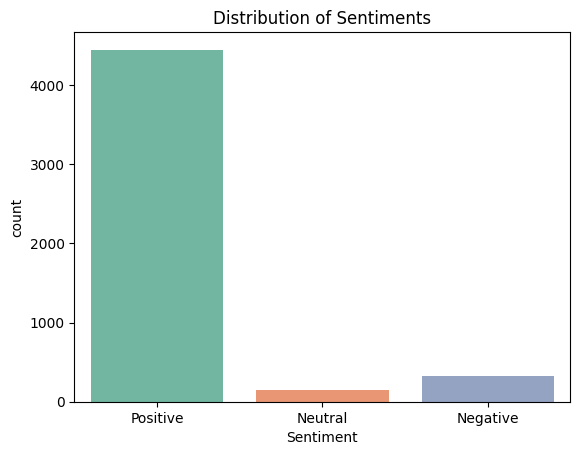

In [ ]:
sns.countplot(data=df, x='Sentiment', palette='Set2')
plt.title("Distribution of Sentiments")
plt.show()


In [ ]:
text =" ".join(review for review in df['Clean_Text'])
print('Total words:', len(text))

Total words: 1263578


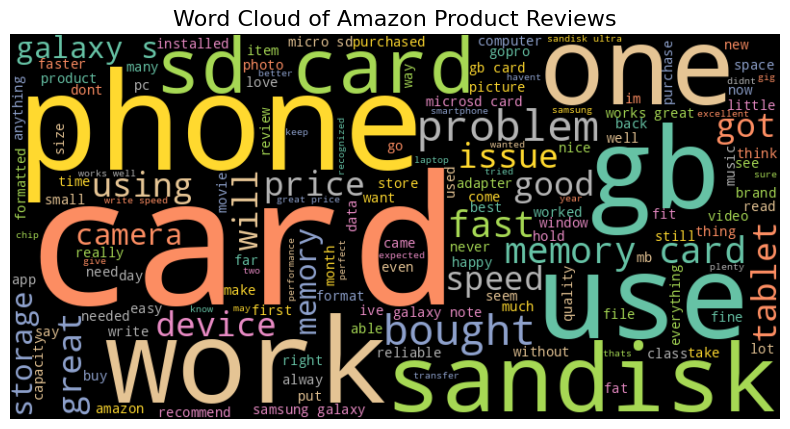

In [ ]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    stopwords=stopwords,
    colormap='Set2',
    max_words=150
).generate(text)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Amazon Product Reviews", fontsize=16)
plt.show()

Separate by Sentiment

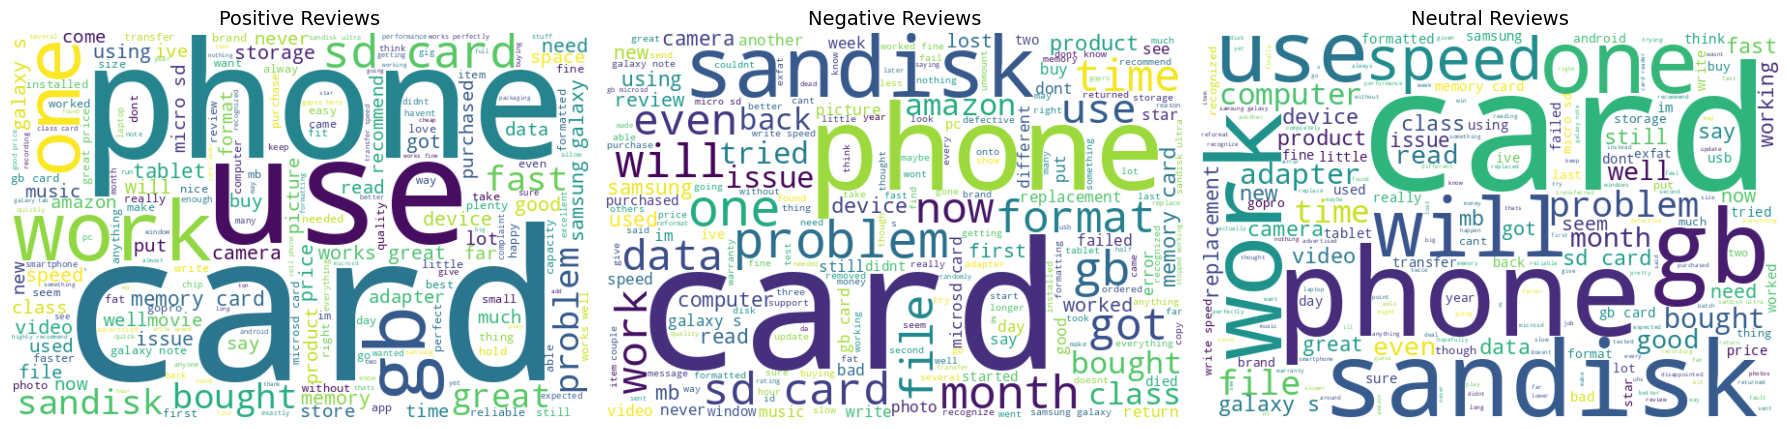

In [ ]:
positive_text = " ".join(review for review in df[df['Sentiment']=='Positive']['Clean_Text'])
negative_text = " ".join(review for review in df[df['Sentiment']=='Negative']['Clean_Text'])
neutral_text = " ".join(review for review in df[df['Sentiment']=='Neutral']['Clean_Text'])


fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, (text, title) in enumerate(zip(
    [positive_text, negative_text, neutral_text],
    ['Positive Reviews', 'Negative Reviews', 'Neutral Reviews']
)):
    wc = WordCloud(width=600, height=400, background_color='white', stopwords=stopwords).generate(text)
    ax[i].imshow(wc, interpolation='bilinear')
    ax[i].set_title(title, fontsize=14)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

Feature Extraction (TF-IDF)

In [68]:
X = df['Clean_Text']
y = df['Sentiment']

tfidf = TfidfVectorizer(max_features=5000,stop_words='english')
X_tfidf = tfidf.fit_transform(X)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [71]:
y_pred = model.predict(X_test)

In [72]:
y_pred

array(['Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Negative', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Negative', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Negative', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positi

In [75]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    Negative       0.77      0.30      0.44        56
     Neutral       0.00      0.00      0.00        30
    Positive       0.93      1.00      0.96       897

    accuracy                           0.93       983
   macro avg       0.57      0.43      0.47       983
weighted avg       0.89      0.93      0.90       983



In [79]:
print( accuracy_score(y_pred,y_test))

0.9277721261444557


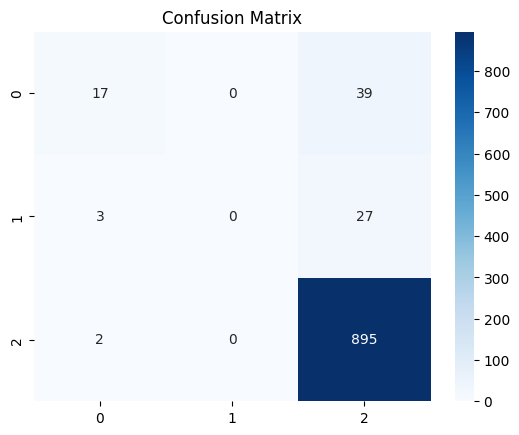

In [76]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [81]:
pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))
